In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, losses
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# HYPERPARAMETERS
image_size = 256
num_classes = 3
dim = 128
depth = 16
heads = 16
mlp_dim = 128
learning_rate = 3e-5
epochs = 8

In [3]:
# PATH DIRECTORY

img_path = "C:/Users/JohnC/Desktop/Datasets/randstainna_HD30000_stained_dataset/"
img_label = ['LUAD', 'LUSC', 'MESO']
img_list = []
label_list = []
for label in img_label:
    for img_file in os.listdir(img_path + label):
        img_list.append(img_path + label + '/' + img_file)
        label_list.append(label)

In [4]:
df = pd.DataFrame({'img': img_list, 'label': label_list})
df_labels = {'LUAD': 0, 'LUSC': 1, 'MESO': 2}
df['encode_label'] = df['label'].map(df_labels)

In [5]:
# RANDOM SAMPLING THE DATA WHERE EACH CLASS HAS AN EVEN NUMBER OF IMAGES FOR TRAINING/TESTING

class_size = 400
sampled_df = df.groupby('label').apply(lambda x: x.sample(class_size, random_state=42)).reset_index(drop=True)

C:\Users\JohnC\AppData\Local\Temp\ipykernel_32048\753029402.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(class_size, random_state=42)).reset_index(drop=True)


In [6]:
batch_size = 16
X = []
y = sampled_df['encode_label'].tolist()
for i in range(0, len(sampled_df), batch_size):
    batch_paths = sampled_df['img'].iloc[i:i + batch_size]
    batch_images = [cv2.imread(str(img)) for img in batch_paths]
    batch_images = [cv2.resize(img, (image_size, image_size)) for img in batch_images]
    batch_images = [img / 255.0 for img in batch_images]
    X.extend(batch_images)

In [7]:
# SPLITTING THE DATA INTO TRAINING AND TESTING GROUPS

X = np.array(X)
y = np.array(y)

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [8]:
# BUILDING THE SINGLE PATCH ViT MODEL ARCHITECTURE

class VisionTransformer(tf.keras.Model):
    def __init__(self, num_patches, num_classes, dim, depth, heads, mlp_dim):
        super(VisionTransformer, self).__init__()
        self.num_patches = num_patches
        self.dim = dim

        self.pos_embedding = self.add_weight("pos_embedding", shape=[1, num_patches + 1, dim])
        self.cls_token = self.add_weight("cls_token", shape=[1, 1, dim])
        
        self.patch_to_embedding = layers.Dense(dim) 

        self.transformer_layers = [
            [
                layers.LayerNormalization(epsilon=1e-6),
                layers.MultiHeadAttention(num_heads=heads, key_dim=dim),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(mlp_dim, activation=tf.keras.activations.gelu),
                layers.Dense(dim)
            ]
            for _ in range(depth)
        ]

        self.mlp_head = models.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(mlp_dim, activation=tf.keras.activations.gelu),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.patch_to_embedding(x)  
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.dim])
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding[:, :tf.shape(x)[1], :]

        for norm1, attn, norm2, mlp1, mlp2 in self.transformer_layers:
            x1 = norm1(x)
            x2 = attn(x1, x1)
            x = x + x2
            x1 = norm2(x)
            x2 = mlp1(x1)
            x2 = mlp2(x2)
            x = x + x2

        x = self.mlp_head(x[:, 0])
        return x

In [9]:
# FRAMEWORK MODIFICATION GUIDELINES TO CREATE THE PCSVI TRANSFORMER

backbone = applications.DenseNet201(
    include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3)
)
backbone.trainable = False 
backbone.load_weights('C:/Users/JohnC/Desktop/CustomWeights/CellNetV5.h5', by_name=True, skip_mismatch=True)

features = backbone.output

compressed_features = layers.GlobalAveragePooling2D()(features)
compressed_features = layers.Dense(dim)(compressed_features) 
compressed_features = tf.expand_dims(compressed_features, axis=1)

single_vector_space = 1
vit_architecture = VisionTransformer(num_patches=single_vector_space, num_classes=num_classes, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim)
transformer_output = vit_architecture(compressed_features)

PCSVI_Transformer = tf.keras.Model(inputs=backbone.input, outputs=transformer_output)
PCSVI_Transformer.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
PCSVI_Transformer.load_weights('C:/Users/JohnC/Desktop/CustomWeights/ScratchViT512PX.h5', by_name=True, skip_mismatch=True)

In [10]:
# MODEL TRAINING

history = PCSVI_Transformer.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/8
60/60 [==============================] - 26s 166ms/step - loss: 0.8897 - accuracy: 0.5938 - val_loss: 0.8788 - val_accuracy: 0.5417
Epoch 2/8
60/60 [==============================] - 6s 94ms/step - loss: 0.6866 - accuracy: 0.6812 - val_loss: 0.7131 - val_accuracy: 0.6750
Epoch 3/8
60/60 [==============================] - 6s 93ms/step - loss: 0.5925 - accuracy: 0.7354 - val_loss: 0.6254 - val_accuracy: 0.7333
Epoch 4/8
60/60 [==============================] - 6s 93ms/step - loss: 0.5650 - accuracy: 0.7594 - val_loss: 0.5829 - val_accuracy: 0.7583
Epoch 5/8
60/60 [==============================] - 6s 94ms/step - loss: 0.4448 - accuracy: 0.8125 - val_loss: 0.6540 - val_accuracy: 0.7083
Epoch 6/8
60/60 [==============================] - 6s 93ms/step - loss: 0.4060 - accuracy: 0.8240 - val_loss: 0.5845 - val_accuracy: 0.7167
Epoch 7/8
60/60 [==============================] - 6s 93ms/step - loss: 0.3469 - accuracy: 0.8427 - val_loss: 0.5647 - val_accuracy: 0.7333
Epoch 8/8
60/60 [=

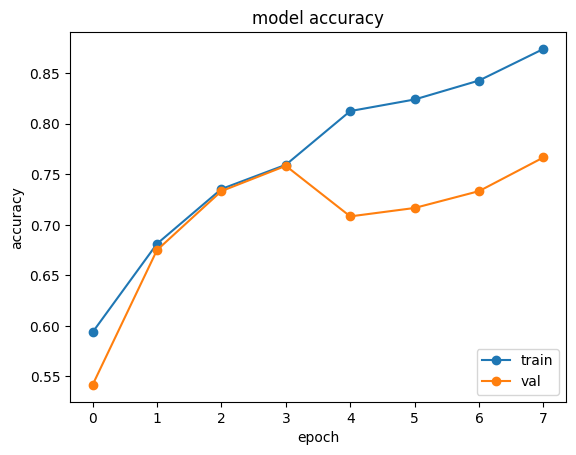

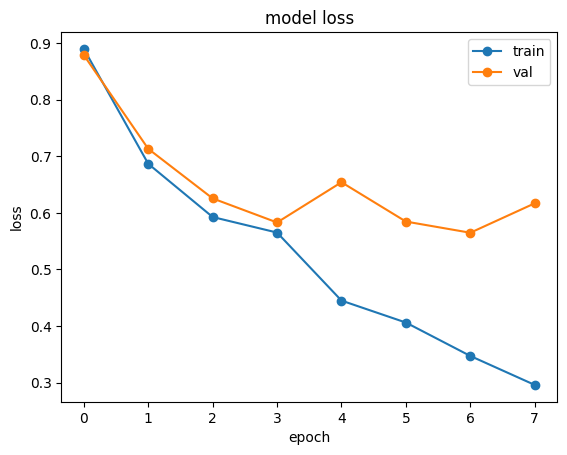

In [11]:
# MODEL PERFORMANCE ANALYSIS

plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [12]:
# PCSVI TRANSFORMER EVALUATION

PCSVI_Transformer.evaluate(X_test, y_test, batch_size=4)

30/30 [==============================] - 2s 49ms/step - loss: 0.6659 - accuracy: 0.7000


[0.6658772230148315, 0.699999988079071]